In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import shap
!pip install lime
from lime.lime_tabular import LimeTabularExplainer




In [4]:
# 1. Create synthetic credit risk dataset

np.random.seed(42)

n = 500
df = pd.DataFrame({
    "age": np.random.randint(21, 65, size=n),
    "income": np.random.randint(20000, 120000, size=n),
    "loan_amount": np.random.randint(1000, 20000, size=n),
    "credit_history": np.random.randint(1, 15, size=n),  # years
    "past_default": np.random.choice([0,1], size=n, p=[0.8,0.2])
})
# Target: default risk (synthetic rule)
df["default"] = (
    (df["loan_amount"]/df["income"] > 0.3) |
    (df["past_default"] == 1) |
    (df["credit_history"] < 3)
).astype(int)

print(df.head())


   age  income  loan_amount  credit_history  past_default  default
0   59   40358         2342              13             1        1
1   49   23267        11568              10             0        1
2   35  102745        19378               9             0        0
3   63  109588        15231               3             1        1
4   28   58513         4490               7             1        1


In [5]:
# 2. Train/test split

X = df.drop(columns=["default"])
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [6]:
# 3. Train Random Forest

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_prob = rf.predict_proba(X_test)[:,1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))

ROC AUC: 0.9987878787878788


/tmp/ipython-input-1313820434.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=X.columns)


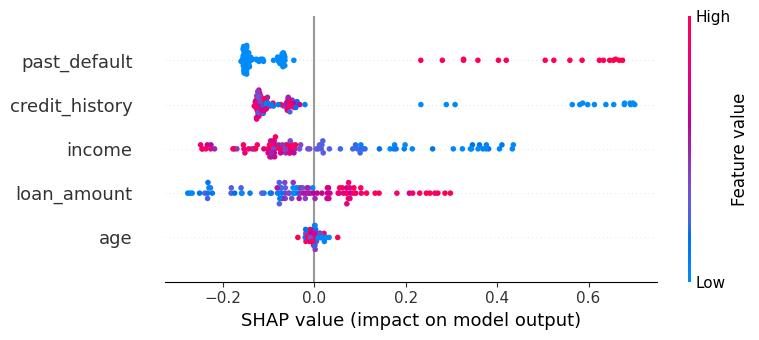

In [8]:
# 4. SHAP global explanation

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=X.columns)

In [9]:
# 5. Borderline case selection (~0.5 probability)

border_idx = np.where((y_prob >= 0.45) & (y_prob <= 0.55))[0]
print("Borderline cases:", border_idx)

Borderline cases: [26 49 65 73]


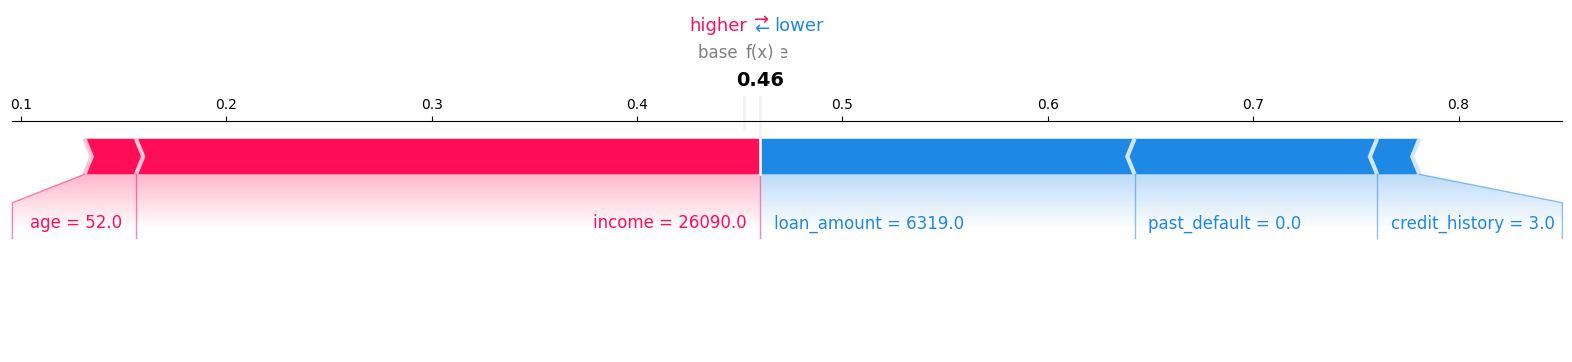

In [11]:
# 6. Local SHAP explanation

if len(border_idx) > 0:
    i = border_idx[0]
    shap.force_plot(explainer.expected_value[1], shap_values[i, :, 1],
                    X_test.iloc[i,:], matplotlib=True)

In [12]:
# 7. LIME explanation

lime_exp = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=["non-default","default"],
    mode="classification"
)

if len(border_idx) > 0:
    i = border_idx[0]
    exp = lime_exp.explain_instance(
        data_row=X_test.iloc[i],
        predict_fn=rf.predict_proba,
        num_features=5
    )
    print("LIME explanation for borderline case:")
    print(exp.as_list())

LIME explanation for borderline case:
[('past_default <= 0.00', -0.6389768926731647), ('credit_history <= 4.00', 0.3378191243079348), ('income <= 41721.25', 0.32850304448506074), ('5445.75 < loan_amount <= 10118.00', -0.08531677087258308), ('44.50 < age <= 53.00', 0.0019997981968306443)]


/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.